# Phase 3: Traditional Machine Learning Models
**Project:** News Document Classification System  
**Goal:** Establish a strong baseline using TF-IDF vectorization and classical ML algorithms (Logistic Regression and SVM).

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import random
# Set the seed for reproducibility
seed_value = 90
np.random.seed(seed_value)
random.seed(seed_value)

In [47]:
# Set visual style
sns.set_theme(style="whitegrid")

## 1. Load Processed Data
We load the "Gold" datasets created in the preprocessing phase.

In [48]:
TRAIN_PATH = "../data/processed/news_clean_train.csv"
TEST_PATH = "../data/processed/news_clean_test.csv"

In [49]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

In [50]:
# Drop any rows with missing text that might have occurred during cleaning
train_df.dropna(subset=['cleaned_text'], inplace=True)
test_df.dropna(subset=['cleaned_text'], inplace=True)

In [51]:
# AG News Class Mapping
label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
target_names = [label_map[i] for i in range(4)]

In [52]:
print(f"Training set: {train_df.shape}")
print(f"Testing set: {test_df.shape}")
train_df.head()

Training set: (120000, 2)
Testing set: (7600, 2)


,label,cleaned_text
0,2,wall bears claw black reuter short seller wall...
1,2,carlyle look commercial aerospace reuters priv...
2,2,oil economy cloud stock outlook reuter soar cr...
3,2,iraq halt oil export main southern pipeline re...
4,2,oil price soar time record pose new menace eco...


## 2. Prepare Features and Labels
We'll use the `cleaned_text` column as our input feature and `label` as our target.

In [53]:
X_train, y_train = train_df['cleaned_text'], train_df['label']
X_test, y_test = test_df['cleaned_text'], test_df['label']

# 3. Model Training & Evaluation Function
We use a Scikit-Learn `Pipeline`. This is a best practice because it encapsulates the feature extraction (TF-IDF) and the classifier into a single object, preventing data leakage and making deployment significantly easier.

In [54]:
def evaluate_model(model, name):
    print(f"\n{'='*20} {name} {'='*20}")
    
    # Fit the pipeline
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {acc:.4f}")
    
    # Print detailed report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return model, acc

## 4. Training Baseline: Logistic Regression
Logistic Regression with TF-IDF is often extremely hard to beat in text classification tasks.

In [55]:
# TF-IDF Parameters:
# - max_features=5000: Limits vocabulary to top 5000 words to keep model size small
# - ngram_range=(1, 2): Captures both single words and pairs (e.g., "social media")
tfidf_params = {'max_features': 5000, 'ngram_range': (1, 2)}


==================== Logistic Regression ====================


Overall Accuracy: 0.9039

Classification Report:
              precision    recall  f1-score   support

       World       0.92      0.90      0.91      1900
      Sports       0.95      0.97      0.96      1900
    Business       0.87      0.86      0.87      1900
    Sci/Tech       0.88      0.88      0.88      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



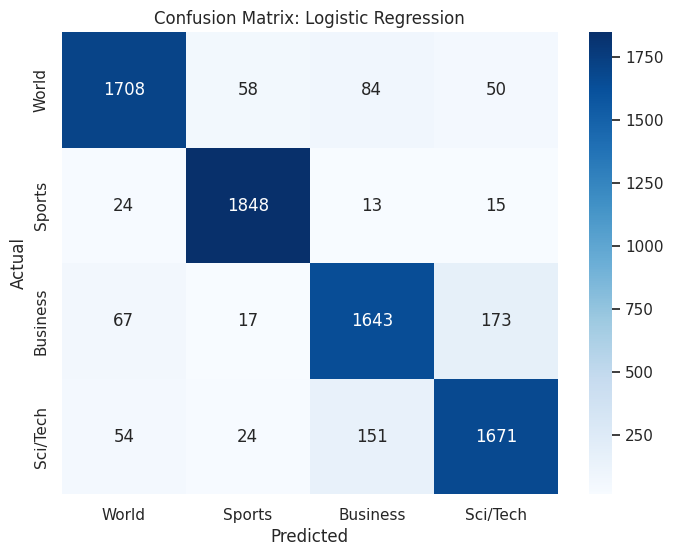

In [56]:
log_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', LogisticRegression(max_iter=1000, random_state=seed_value))
])

log_model, log_acc = evaluate_model(log_pipeline, "Logistic Regression")

## 5. Training Challenger: Support Vector Machine (SVM)
Linear SVMs are mathematically well-suited for high-dimensional sparse text data.


==================== Linear SVM ====================
Overall Accuracy: 0.9071

Classification Report:
              precision    recall  f1-score   support

       World       0.92      0.90      0.91      1900
      Sports       0.95      0.98      0.96      1900
    Business       0.87      0.87      0.87      1900
    Sci/Tech       0.88      0.88      0.88      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



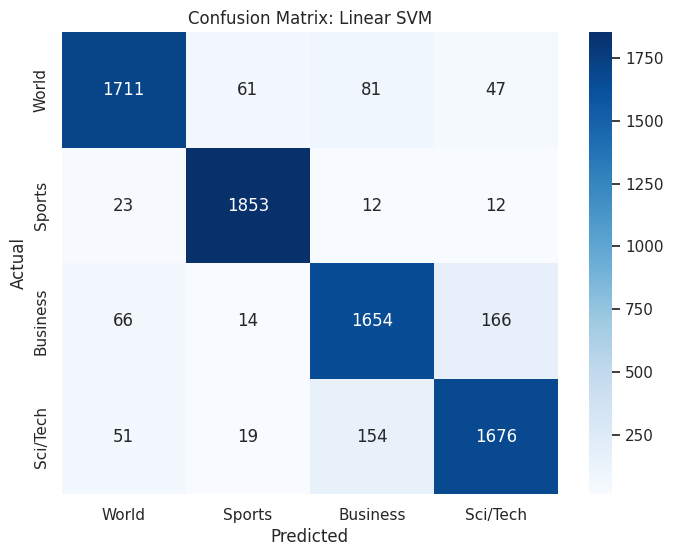

In [57]:
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', LinearSVC(random_state=seed_value))
])

svm_model, svm_acc = evaluate_model(svm_pipeline, "Linear SVM")

## 6. Save Models for Production
We will save both pipelines to the `models/` directory. These files include both the "translator" (TF-IDF) and the "brain" (The Model).

In [58]:
# Create directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the Logistic Regression Model
joblib.dump(log_model, '../models/logistic_model.pkl')

# Save the SVM Model
joblib.dump(svm_model, '../models/svm_model.pkl')

print("Success: Models saved in ../models/")

Success: Models saved in ../models/


## 7. Quick Inference Test
Let's verify that the saved model can be loaded and predict on raw text.

In [59]:
# Load the saved Logistic Regression model
model_path = '../models/logistic_model.pkl'
loaded_model = joblib.load(model_path)


# Sample test cases
samples = [
    "The central bank raised interest rates to combat inflation.",
    "The championship game went into double overtime last night.",
    "New discoveries in quantum computing could revolutionize encryption."
]

preds = loaded_model.predict(samples)

print(f"Model Loaded from: {model_path}\n")
for text, p in zip(samples, preds):
    print(f"Text: {text}")
    print(f"Predicted: {label_map[p]}\n")

Model Loaded from: ../models/logistic_model.pkl

Text: The central bank raised interest rates to combat inflation.
Predicted: Business

Text: The championship game went into double overtime last night.
Predicted: Sports

Text: New discoveries in quantum computing could revolutionize encryption.
Predicted: Sci/Tech



## 7 Summary & Next Steps

A strong performance baseline was established using traditional NLP methodologies. The combination of TF-IDF feature extraction and linear classifiers resulted in a test accuracy of 90.39%. This result serves as the primary metric against which more complex deep learning architectures will be measured.


**Next Phase:** The workflow advances to **Deep Learning Model.** This phase will explore word embeddings and neural network architectures to determine if semantic sequence modeling can exceed the established 90.39% baseline.